In [22]:
import cv2
from manga_ocr import MangaOcr
import numpy as np
from PIL import Image
from skimage import measure, morphology
import matplotlib.pyplot as plt
from googletrans import Translator

In [23]:
PATH_OF_THE_FOLDER = "./images/training/"
NAME_OF_THE_FILE = "AisazuNihaIrarenai.jpg"

name = NAME_OF_THE_FILE.split(".")[0]

PATH_OF_THE_RESULTS_FOLDER = PATH_OF_THE_FOLDER + name + '-results/'

### Detect boxes (around the texts)

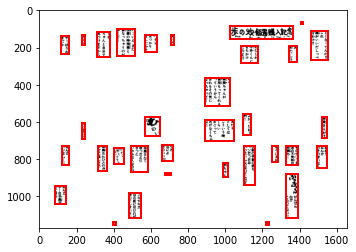

In [24]:
# Load the image
img = Image.open(PATH_OF_THE_RESULTS_FOLDER + "only_text.png").convert("L") # Convert to grayscale
img_arr = np.array(img)

# Threshold the image
binary = img_arr < 128

# Apply erosion and dilation to merge small blocks
kernel = morphology.square(20)
binary = morphology.binary_dilation(binary, kernel)
binary = morphology.binary_erosion(binary, kernel)

# Label connected regions of black pixels
label_image = measure.label(binary)
all_images = []

# Extract bounding boxes for each labeled region
for region in measure.regionprops(label_image):
    y1, x1, y2, x2 = region.bbox

    roi = img.crop((x1, y1, x2, y2))
    all_images.append([roi, (x1, y1, x2, y2)])

    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)

plt.imshow(img_arr, cmap='gray')
plt.show()

### Translate part

In [25]:
mocr = MangaOcr()
translator = Translator()

all_texts = []

# Put all the images here with to get text
for img, pos in all_images:
    text = mocr(img)
    all_texts.append([text, pos])

# Translate all texts
all_texts_joined = ""
for text, _ in all_texts:
    all_texts_joined += text + "\n"
tanslated_texts = translator.translate(all_texts_joined, dest="en").text

final_texts = []
for tanslated_text, (_, pos) in zip(tanslated_texts.split('\n'), all_images):
    final_texts.append([tanslated_text, pos])


2023-04-02 18:16:24.759 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2023-04-02 18:16:30.403 | INFO     | manga_ocr.ocr:__init__:22 - Using CPU
2023-04-02 18:16:32.057 | INFO     | manga_ocr.ocr:__init__:29 - OCR ready


### Create translation layer

In [26]:
height, width = img_arr.shape
translated_image = np.zeros((height, width, 3), dtype=np.uint8)

### Put the translation at the good places in the boxes

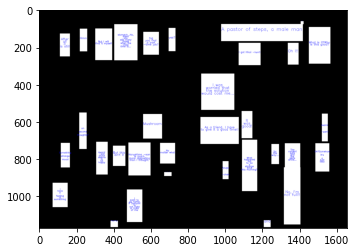

True

In [27]:
def cut_sentence(sentence):
    lines = sentence.split("\n")
    result = []
    for line in lines:
        words = line.split()
        half_len = len(words) // 2
        first_half = ' '.join(words[:half_len])
        second_half = ' '.join(words[half_len:])
        result.append(first_half)
        result.append(second_half)
    return "\n".join(result)

def get_multiline_text_size(text, font, font_scale, thickness):
    lines = text.split('\n')
    max_width = 0
    total_height = 0
    for line in lines:
        (width, height), _ = cv2.getTextSize(line, font, font_scale, thickness)
        max_width = max(max_width, width)
        total_height += height
    return max_width, total_height

def put_text_with_newlines_centered(img, text, box, font, font_scale, color, thickness):
    lines = text.split('\n')
    line_height = cv2.getTextSize('A', font, font_scale, thickness)[0][1]
    total_height = line_height * len(lines)
    text_y = int((box[1] + box[3] - total_height) / 2)  # center vertically
    for line in lines:
        (text_width, _), _ = cv2.getTextSize(line, font, font_scale, thickness)
        text_x = int((box[0] + box[2] - text_width) / 2)  # center horizontally
        cv2.putText(img, line, (text_x, text_y), font, font_scale, color, thickness)
        text_y += line_height


font = cv2.FONT_HERSHEY_SIMPLEX
max_attempts = 3
for text, pos in final_texts:
    x1, y1, x2, y2 = pos
    
    not_good = True
    attempts = 0

    # Adjust boxes sizes
    width = abs(x1 - x2)
    height = abs(y1 - y2)
    if width > 20:
        percentage_box = 0.15
    else:
        percentage_box = 0.65
    x1 -= int(width * percentage_box)
    x2 += int(width * percentage_box)
    y1 -= int(height * percentage_box)
    y2 += int(height * percentage_box)

    while not_good is True and attempts < max_attempts:
        scale = 1

        while not_good is True:
            text_width, text_height = get_multiline_text_size(text, font, scale, 1)
            if text_width > (x2 - x1):
                scale -= 0.01
            else:
                not_good = False
            if scale < 0.4:
                attempts += 1
                break

        if not_good is True:
            text = cut_sentence(text)

    # Draw the rectangle and text
    cv2.rectangle(translated_image, (x1, y1), (x2, y2), (255, 255, 255), -1)
    put_text_with_newlines_centered(translated_image, text, pos, font, scale, (0, 0, 255), 1)

plt.imshow(translated_image)
plt.show()

cv2.imwrite(PATH_OF_THE_RESULTS_FOLDER + "translated_layer.png", translated_image)

### Merge original image and translated layer

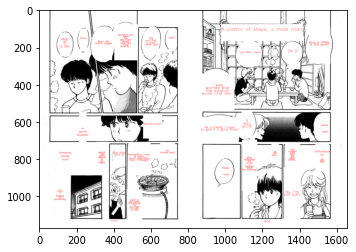

In [28]:
# Load the two images
image1 = Image.open(PATH_OF_THE_FOLDER + NAME_OF_THE_FILE)
image2 = Image.open(PATH_OF_THE_RESULTS_FOLDER + "translated_layer.png")

# Convert the second image to RGBA mode to support transparency
image2 = image2.convert("RGBA")

# Loop through each pixel in the second image
for x in range(image2.width):
    for y in range(image2.height):
        # Get the pixel color at (x, y)
        pixel = image2.getpixel((x, y))
        
        # If the pixel is black, set the alpha channel to 0 (transparent)
        if pixel == (0, 0, 0, 255):
            image2.putpixel((x, y), (0, 0, 0, 0))
            
# Overlay the second image on top of the first image
image1.paste(image2, (0, 0), image2)

plt.imshow(image1)
plt.show()

# Save the final image
image1.save(PATH_OF_THE_RESULTS_FOLDER + "final_result.png")